Import libraries and load dataset

In [2]:
#Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Load the train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
# Combine train and test datasets for consistent preprocessing
combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])

EDA Steps

In [6]:
# Data Overview
print("Data Overview:")
print(combined_df.info())  # Info about the data types and non-null counts

Data Overview:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2

In [7]:
# Missing Value Analysis
missing_values = combined_df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print("\nMissing Values Count:")
print(missing_values)


Missing Values Count:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
KitchenQual        1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
GarageCars         1
Exterior2nd        1
Exterior1st        1
GarageArea         1
dtype: int64


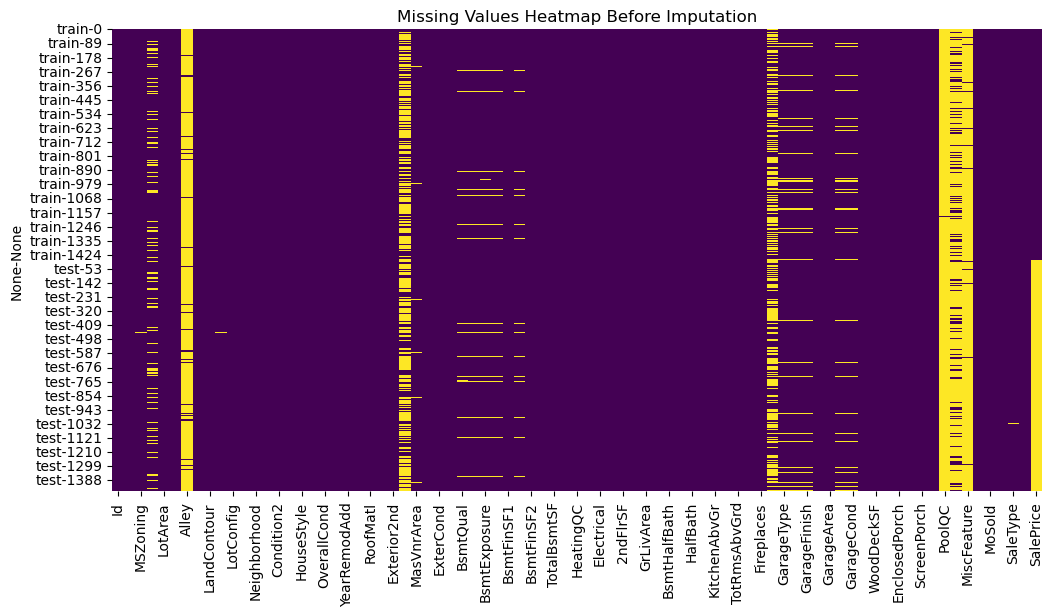

In [8]:
# Visualization: Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(combined_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap Before Imputation")
plt.show()

In [9]:
# Summary Statistics
print("\nSummary Statistics:")
print(combined_df.describe())  # Descriptive statistics of numerical features


Summary Statistics:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235  ...   
std       1.113131    30.291442     20.894344   179.33

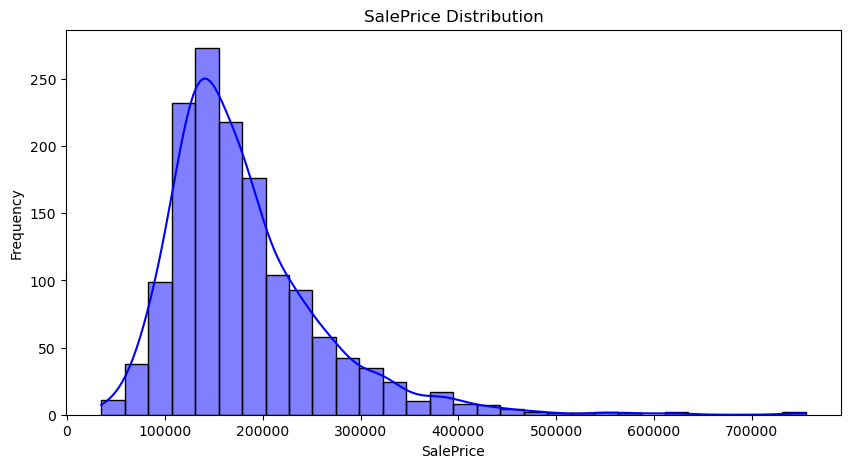

In [10]:
# Target Variable (SalePrice) Analysis
plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'], kde=True, color='blue', bins=30)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

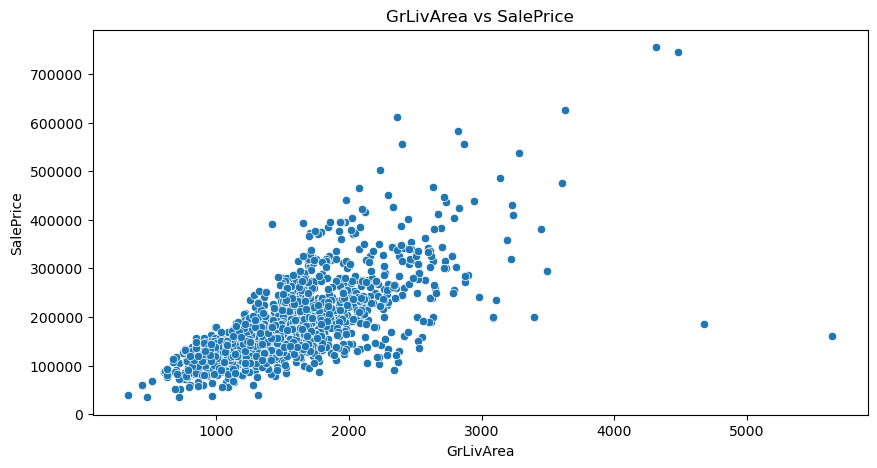

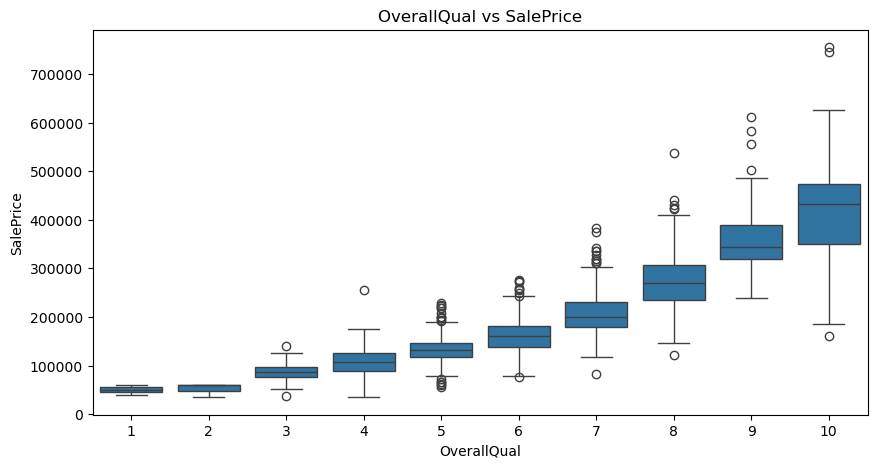

In [11]:
# Feature-Target Relationships
# Strong predictors of house prices (SalePrice) in housing datasets - GrLivArea and OverallQual
# Scatter Plot: GrLivArea vs SalePrice
plt.figure(figsize=(10, 5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title("GrLivArea vs SalePrice")
plt.show()

# Box Plot: OverallQual vs SalePrice
plt.figure(figsize=(10, 5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title("OverallQual vs SalePrice")
plt.show()


<Figure size 1600x1200 with 0 Axes>

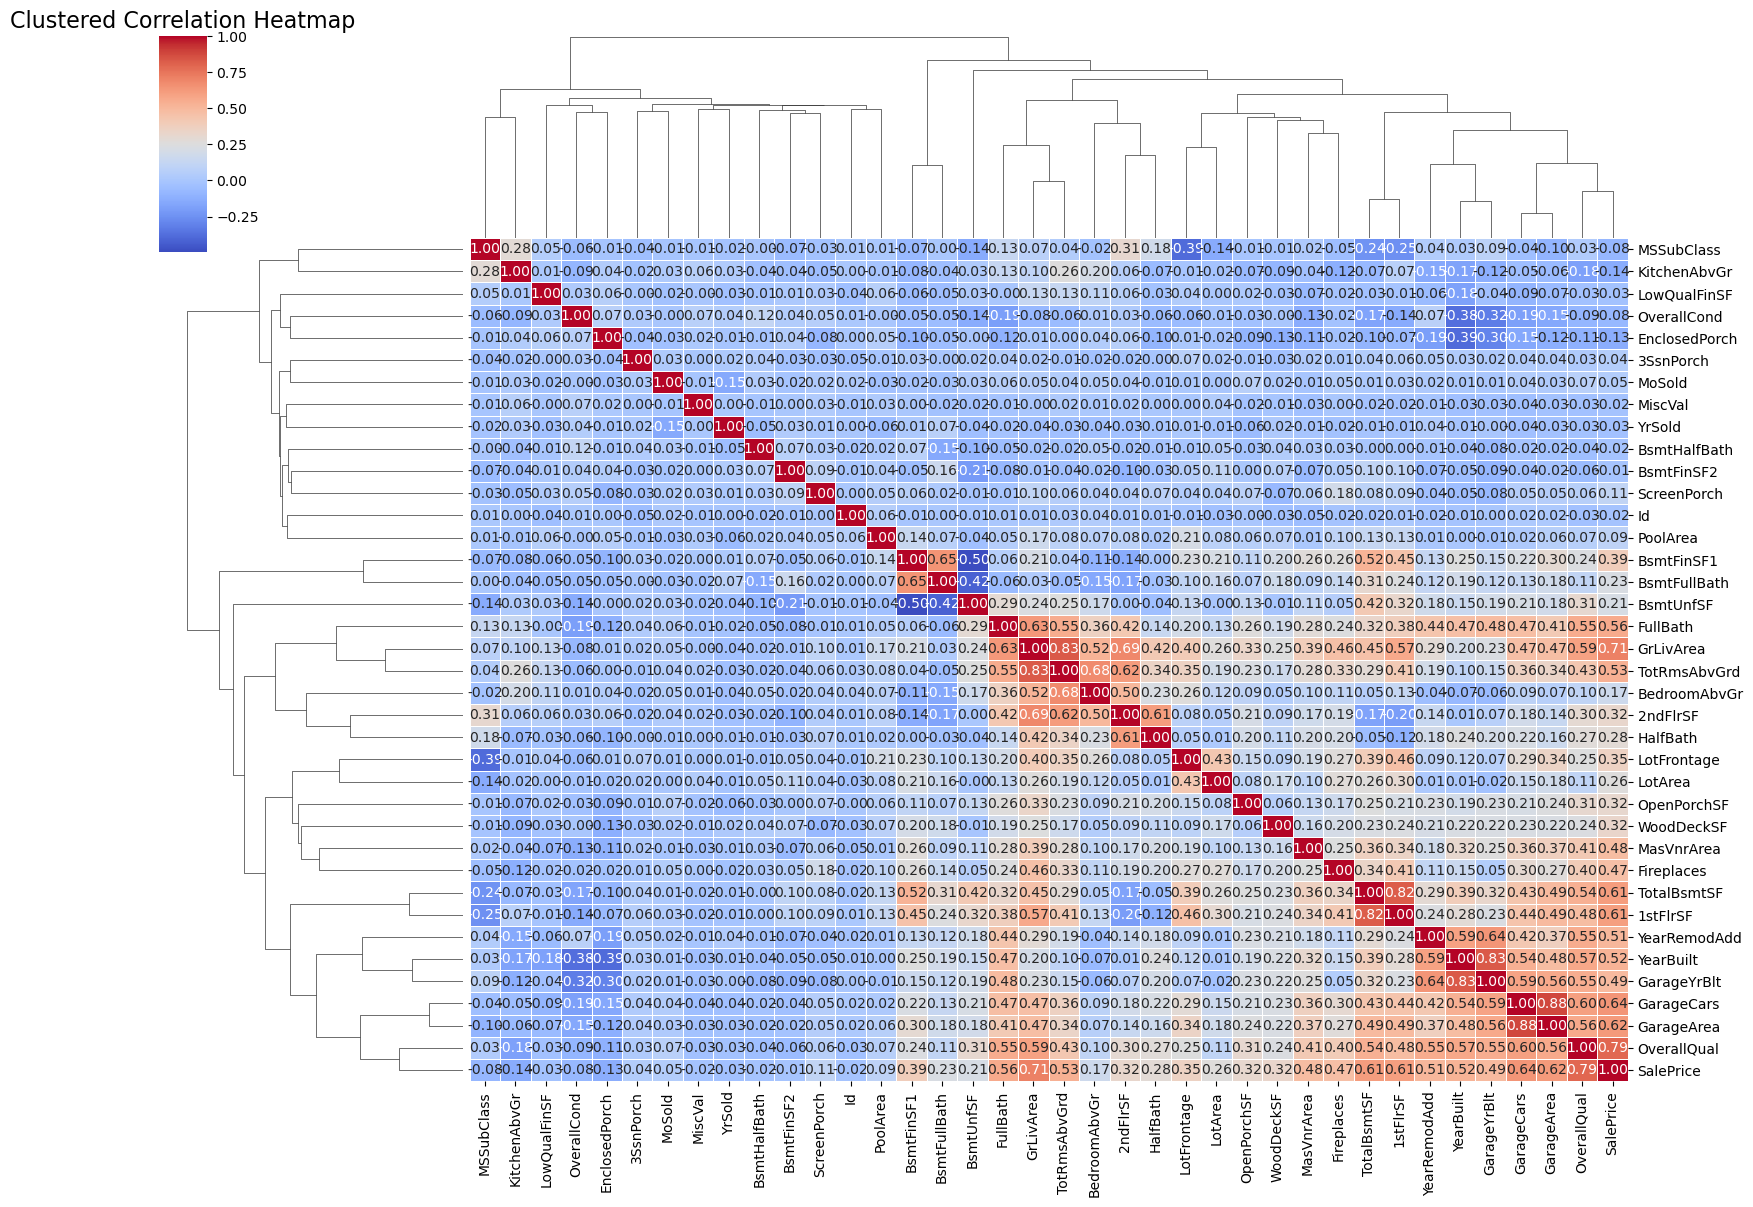

In [12]:
# Compute the correlation matrix for numerical columns
numeric_columns = train_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()

# Use hierarchical clustering to reorder the correlation matrix
linkage_matrix = linkage(corr_matrix, method='average')

# Plot the clustered heatmap
plt.figure(figsize=(16, 12))
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", figsize=(16, 12),
               linewidths=0.5, dendrogram_ratio=(0.2, 0.2), cbar_pos=(0, 0.8, 0.03, 0.18))
plt.title("Clustered Correlation Heatmap", fontsize=16)
plt.show()

In [13]:
# Separate numerical and categorical columns
train_numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_numerical_cols = train_numerical_cols.drop('SalePrice')
train_categorical_cols = train_df.select_dtypes(include=['object']).columns

test_numerical_cols = test_df.select_dtypes(include=['float64', 'int64']).columns
test_categorical_cols = test_df.select_dtypes(include=['object']).columns

In [14]:
# Apply Median Imputation to numerical columns
num_imputer = SimpleImputer(strategy='median')
train_df[train_numerical_cols] = num_imputer.fit_transform(train_df[train_numerical_cols])
test_df[train_numerical_cols] = num_imputer.fit_transform(test_df[train_numerical_cols])

In [15]:
# Apply Most Frequent Imputation to categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[train_categorical_cols] = cat_imputer.fit_transform(train_df[train_categorical_cols])
test_df[test_categorical_cols] = cat_imputer.fit_transform(test_df[test_categorical_cols])

In [16]:
# For train_df
train_df = train_df.copy()  # working on a copy of the original DataFrame

# Creating TotalArea for train_df
train_df['TotalArea'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['TotalBsmtSF']

# Creating TotalBathrooms for train_df
train_df['TotalBathrooms'] = train_df['FullBath'] + (0.5 * train_df['HalfBath']) + train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath'])

# Quality-to-Area Ratio for train_df
train_df['QualityToAreaRatio'] = train_df['OverallQual'] / train_df['TotalArea']

# HouseAge for train_df
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']

# Drop redundant columns for train_df
train_df = train_df.drop(columns=['GarageArea', 'TotRmsAbvGrd', 'MSSubClass', 'OverallCond', 'LowQualFinSF', 'EnclosedPorch', 'ScreenPorch'], 
                         errors='ignore')


# For test_df
test_df = test_df.copy()  # working on a copy of the original DataFrame

# Creating TotalArea for test_df
test_df['TotalArea'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['TotalBsmtSF']

# Creating TotalBathrooms for test_df
test_df['TotalBathrooms'] = test_df['FullBath'] + (0.5 * test_df['HalfBath']) + test_df['BsmtFullBath'] + (0.5 * test_df['BsmtHalfBath'])

# Quality-to-Area Ratio for test_df
test_df['QualityToAreaRatio'] = test_df['OverallQual'] / test_df['TotalArea']

# HouseAge for test_df
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

# Drop redundant columns for test_df
test_df = test_df.drop(columns=['GarageArea', 'TotRmsAbvGrd', 'MSSubClass', 'OverallCond', 'LowQualFinSF', 'EnclosedPorch', 'ScreenPorch'], 
                       errors='ignore')


In [17]:
# Apply Polynomial Feature Expansion to GrLivArea and OverallQual (optional, based on further analysis)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Apply Polynomial Expansion to selected features
train_poly = poly.fit_transform(train_df[['GrLivArea', 'OverallQual']])
test_poly = poly.transform(test_df[['GrLivArea', 'OverallQual']])

# Add polynomial features to the DataFrame
train_poly_df = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(['GrLivArea', 'OverallQual']))
test_poly_df = pd.DataFrame(test_poly, columns=poly.get_feature_names_out(['GrLivArea', 'OverallQual']))

train_df = pd.concat([train_df, train_poly_df], axis=1)
test_df = pd.concat([test_df, test_poly_df], axis=1)

In [18]:
# Define the final set of features to keep
features_to_keep = list(set(['OverallQual', 'TotalArea', 'GrLivArea', 'GarageCars', 'TotalBathrooms', 
                    'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'QualityToAreaRatio'] + list(train_poly_df.columns)))

# Retain only the selected features for both train and test datasets
X_train_full = train_df[features_to_keep]
y_train_full = train_df['SalePrice']

# Test set
X_test_full = test_df[features_to_keep]

In [19]:
# Saving the pre-processed data into CSV files for both train and test datasets

# Save the train data (features and target)
train_df_preprocessed = X_train_full.copy()
train_df_preprocessed['SalePrice'] = y_train_full  # Add target column back to the training data
train_df_preprocessed.to_csv('preprocessed_train.csv', index=False)

# Save the test data (features only)
X_test_full.to_csv('preprocessed_test.csv', index=False)

print("Preprocessed data saved as 'preprocessed_train.csv' and 'preprocessed_test.csv'.")

Preprocessed data saved as 'preprocessed_train.csv' and 'preprocessed_test.csv'.


In [20]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Train the model
gbr_model.fit(X_train, y_train)

# Predictions on training and validation sets
y_train_pred = gbr_model.predict(X_train)
y_val_pred = gbr_model.predict(X_val)

# Evaluating the model
evaluation_metrics = {
    "RMSE": {
        "train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "validation": np.sqrt(mean_squared_error(y_val, y_val_pred))
    },
    "MAE": {
        "train": mean_absolute_error(y_train, y_train_pred),
        "validation": mean_absolute_error(y_val, y_val_pred)
    },
    "R2 Score": {
        "train": r2_score(y_train, y_train_pred),
        "validation": r2_score(y_val, y_val_pred)
    }
}

# Print evaluation metrics
print("Model Evaluation Metrics:")
for metric, values in evaluation_metrics.items():
    print(f"{metric}:")
    print(f"  Train: {values['train']}")
    print(f"  Validation: {values['validation']}")

Model Evaluation Metrics:
RMSE:
  Train: 18644.249773395608
  Validation: 26950.671848301998
MAE:
  Train: 13896.946986573515
  Validation: 18191.192757430395
R2 Score:
  Train: 0.9417209969771205
  Validation: 0.9053053685781609


In [21]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
gbr_model = GradientBoostingRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get best model and evaluation metrics
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [22]:
# Initialize Gradient Boosting Regressor with the best parameters
best_gbr_model = GradientBoostingRegressor(
    learning_rate=0.05, 
    max_depth=3, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42
)

# Train the model with the best parameters on the full training data
best_gbr_model.fit(X_train_full, y_train_full)

# Make predictions on the training and validation sets
y_train_pred = best_gbr_model.predict(X_train_full)
y_val_pred = best_gbr_model.predict(X_val)

# Evaluate the model
evaluation_metrics = {
    "RMSE": {
        "train": np.sqrt(mean_squared_error(y_train_full, y_train_pred)),
        "validation": np.sqrt(mean_squared_error(y_val, y_val_pred))
    },
    "MAE": {
        "train": mean_absolute_error(y_train_full, y_train_pred),
        "validation": mean_absolute_error(y_val, y_val_pred)
    },
    "R2 Score": {
        "train": r2_score(y_train_full, y_train_pred),
        "validation": r2_score(y_val, y_val_pred)
    }
}

# Print evaluation metrics
print("Model Evaluation Metrics after Hyperparameter Tuning:")
for metric, values in evaluation_metrics.items():
    print(f"{metric}:")
    print(f"  Train: {values['train']}")
    print(f"  Validation: {values['validation']}")


Model Evaluation Metrics after Hyperparameter Tuning:
RMSE:
  Train: 19418.57679455725
  Validation: 19832.93805452014
MAE:
  Train: 14122.645556458856
  Validation: 14060.44626805967
R2 Score:
  Train: 0.9402102798241757
  Validation: 0.9487185523471131


In [23]:
# Predict on test set
y_test_pred = best_gbr_model.predict(X_test_full)

# Save the predictions to a CSV for submission
submission = pd.DataFrame({
    'Id': test_df['Id'],  # Ensure 'Id' is included in the test data
    'SalePrice': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print("Test predictions saved as 'submission.csv'.")

Test predictions saved as 'submission.csv'.


In [24]:
import joblib

joblib.dump(best_gbr_model, 'gbr_model.pkl')
print("Model saved to 'gbr_model.pkl'.") 

feature_names = X_train.columns  
joblib.dump(feature_names, 'gbr_feature_names.pkl')

Model saved to 'gbr_model.pkl'.


['gbr_feature_names.pkl']